In [1]:
import torch
import torchvision

print(torch.__version__)      # Should print 2.6.0
print(torchvision.__version__)  # Should print something like 0.17.0

print(torch.backends.mps.is_available())  # Should return True for Apple Silicon


2.6.0
0.21.0
True


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Stronger Augmentation for Small Dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)), 
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.6, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset_path = "dataset"
train_data = datasets.ImageFolder(root=f"{dataset_path}/train", transform=train_transform)
val_data = datasets.ImageFolder(root=f"{dataset_path}/val", transform=val_transform)
test_data = datasets.ImageFolder(root=f"{dataset_path}/test", transform=val_transform)

# ✅ Reduce Batch Size for Small Dataset
batch_size = 4  

# ✅ Handle Class Imbalance
class_counts = torch.bincount(torch.tensor(train_data.targets))
class_weights = 1.0 / class_counts.float()
sample_weights = [class_weights[label] for _, label in train_data.samples]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_data) * 5, replacement=True)  # ✅ Oversample

# Data Loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ✅ Use ResNet-101 for Stronger Transfer Learning
class CustomResNet101(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet101, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        return self.model(x)

num_classes = len(train_data.classes)
model = CustomResNet101(num_classes=num_classes).to(device)

# ✅ Use Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ✅ Lower Learning Rate for Better Convergence
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# ✅ Cosine Annealing LR Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# ✅ Train for More Epochs (Small Dataset)
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50):
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        scheduler.step()

        # ✅ Save Best Model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")
    
    # Plot Training & Validation Loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Val Loss", color="red")
    plt.legend()
    plt.title("Loss Curve")
    
    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Val Accuracy", color="green")
    plt.legend()
    plt.title("Validation Accuracy")
    
    plt.show()

# Evaluation function (Validation & Testing)
def evaluate(model, data_loader, criterion):
    model.eval()
    correct, total, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(data_loader), correct / total

# ✅ Function to Evaluate Test Accuracy
def test_model(model, test_loader, criterion):
    model.load_state_dict(torch.load("best_model.pth"))  # Load best model
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"Test Accuracy: {test_acc:.2f}")
    return test_acc

# ✅ Train the model (Longer Training for Small Dataset)
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50)

# ✅ Evaluate on Test Set
test_model(model, test_loader, criterion)


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /Users/md.saminisrak/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|███████████████████████████████████████████████████████████| 171M/171M [00:23<00:00, 7.77MB/s]


Epoch 1/50, Loss: 1.9332, Train Acc: 0.47, Val Acc: 0.11
Epoch 2/50, Loss: 1.1437, Train Acc: 0.78, Val Acc: 0.12
Epoch 3/50, Loss: 0.8911, Train Acc: 0.88, Val Acc: 0.11
Epoch 4/50, Loss: 0.7765, Train Acc: 0.92, Val Acc: 0.12
Epoch 5/50, Loss: 0.7145, Train Acc: 0.95, Val Acc: 0.13
Epoch 6/50, Loss: 0.6771, Train Acc: 0.96, Val Acc: 0.15
Epoch 7/50, Loss: 0.6570, Train Acc: 0.97, Val Acc: 0.13
Epoch 8/50, Loss: 0.6291, Train Acc: 0.98, Val Acc: 0.14
Epoch 9/50, Loss: 0.6168, Train Acc: 0.98, Val Acc: 0.15


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/torchvision/datasets/folder.py", line 284, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/torchvision/datasets/folder.py", line 262, in pil_loader
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train/cartographic_art/01.jpg'


In [28]:
torch.save(model.state_dict(), "resnet50_model_1.pth")

// Classifying an image. 

In [29]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load model
model = models.resnet50(pretrained=False)
num_classes = 3  # Adjust based on your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load trained weights
model.load_state_dict(torch.load("resnet50_model_1.pth", map_location=torch.device("mps")))
model.eval()  # Set model to evaluation mode

# Move model to MPS (Apple GPU) if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)


In [30]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


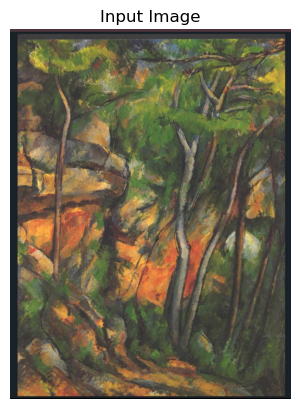

Predicted Art Style: cubism


In [47]:
# Set the path to your test directory
test_dir = "dataset/test"

# Choose a sample image (Modify the path if needed)
sample_image_path = os.path.join(test_dir, "cubism", "67.jpg")  # Replace with an actual image file

# Load the image
image = Image.open(sample_image_path)

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.title("Input Image")
plt.show()

# Preprocess the image
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

# Define class labels
class_labels = ["cubism", "fauvism", "surrealism"]

# Print prediction
print(f"Predicted Art Style: {class_labels[predicted_class]}")
